# Getting Started with IViS

In [7]:
from ivis.imager import Imager

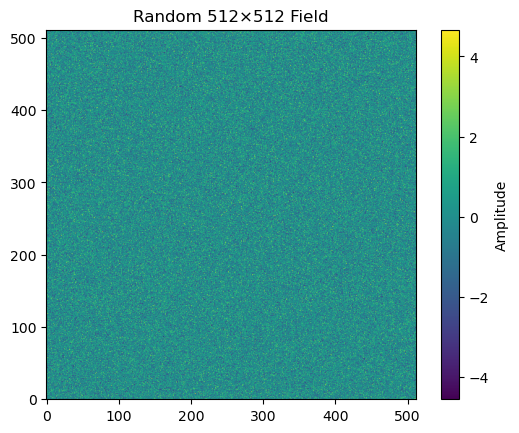

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random 512x512 field
field = np.random.randn(512, 512)

# Display it
plt.imshow(field, origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Random 512×512 Field")
plt.show()